# Panorama Stitching using ORB
This notebook performs image stitching using ORB feature detection, feature matching, and homography transformation.

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Load Images

In [23]:
def load_images(image_paths):
    return [cv2.imread(p) for p in image_paths if p is not None]


## ORB Feature Detection

In [24]:
def detect_keypoints_and_descriptors(images):
    orb = cv2.ORB_create()
    keypoints_list, descriptors_list = [], []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = orb.detectAndCompute(gray, None)
        keypoints_list.append(keypoints)
        descriptors_list.append(descriptors)
    return keypoints_list, descriptors_list

## Feature Matching

In [25]:
def match_features(descriptors_list):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches_list = []
    for i in range(len(descriptors_list) - 1):
        matches = bf.match(descriptors_list[i], descriptors_list[i+1])
        matches_list.append(sorted(matches, key=lambda x: x.distance))
    return matches_list

## Compute Homographies

In [26]:
def compute_homographies(keypoints_list, matches_list):
    homographies = []
    for i, matches in enumerate(matches_list):
        src_pts = np.float32([keypoints_list[i][m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_list[i+1][m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
        homographies.append(H)
    return homographies

## Stitch Images

In [27]:
def stitch_images(images, homographies):
    panorama = images[0]

    for i in range(1, len(images)):
        H = homographies[i - 1]
        h1, w1 = panorama.shape[:2]
        h2, w2 = images[i].shape[:2]
        warped_img = cv2.warpPerspective(images[i], H, (w1 + w2, h1))
        warped_img[0:h1, 0:w1] = panorama
        panorama = warped_img

    # Crop black areas
    gray_panorama = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_panorama, 1, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    return panorama[y:y+h, x:x+w]

## Display and Save Result

In [ ]:
def display_and_save(panorama, output_path):
    
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    cv2.imwrite(output_path, panorama)

In [ ]:
def stitch_images_from_paths(image_paths, output_path):
    images = load_images(image_paths)
    keypoints_list, descriptors_list = detect_keypoints_and_descriptors(images)
    matches_list = match_features(descriptors_list)
    homographies = compute_homographies(keypoints_list, matches_list)
    panorama = stitch_images(images, homographies)
    display_and_save(panorama, output_path)

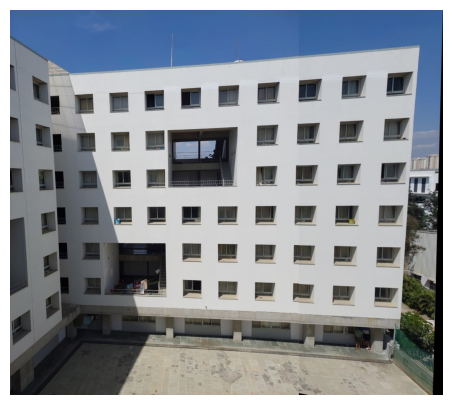

In [33]:
input_1 = ["images/left_1.jpg", "images/center_1.jpg", "images/right_1.jpg"]
stitch_images_from_paths(input_1, "outputs/panorama_1.jpg")

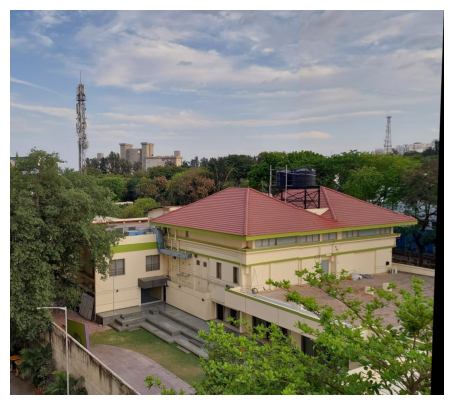

In [34]:
input_2 = ["images/left_2.jpg", "images/center_2.jpg", "images/right_2.jpg"]
stitch_images_from_paths(input_2, "outputs/panorama_2.jpg")